## POPULAR DESTINATIONS
What are the most popular destinations for travelers?

In [37]:
# Dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import hvplot.pandas

# Import API key
from config import geoapify_key

In [38]:
# Reference the file where the CSV is located
hotel_booking_csv = Path("../Resources/hotel_bookings_dataset.csv")

# Import the date into a Pandas DataFrame
hotel_booking_df = pd.read_csv(hotel_booking_csv)
print(hotel_booking_df.head())

          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1     

## Cleaning Data

In [39]:
#Check DataFrame info
hotel_booking_df.info

<bound method DataFrame.info of                hotel  is_canceled  lead_time  arrival_date_year  \
0       Resort Hotel            0        342               2015   
1       Resort Hotel            0        737               2015   
2       Resort Hotel            0          7               2015   
3       Resort Hotel            0         13               2015   
4       Resort Hotel            0         14               2015   
...              ...          ...        ...                ...   
119385    City Hotel            0         23               2017   
119386    City Hotel            0        102               2017   
119387    City Hotel            0         34               2017   
119388    City Hotel            0        109               2017   
119389    City Hotel            0        205               2017   

       arrival_date_month  arrival_date_week_number  \
0                    July                        27   
1                    July                        27  

In [40]:
hotel_booking_df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [41]:
# Select working columns
hotel_booking_drop_columns_df = hotel_booking_df[["country", "arrival_date_year",
       "arrival_date_month", "is_canceled", "adults", "children", "babies", "stays_in_weekend_nights", "stays_in_week_nights", "is_repeated_guest"]]
hotel_booking_drop_columns_df

,country,arrival_date_year,arrival_date_month,is_canceled,adults,children,babies,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest
0,PRT,2015,July,0,2,0.0,0,0,0,0
1,PRT,2015,July,0,2,0.0,0,0,0,0
2,GBR,2015,July,0,1,0.0,0,0,1,0
3,GBR,2015,July,0,1,0.0,0,0,1,0
4,GBR,2015,July,0,2,0.0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...
119385,BEL,2017,August,0,2,0.0,0,2,5,0
119386,FRA,2017,August,0,3,0.0,0,2,5,0
119387,DEU,2017,August,0,2,0.0,0,2,5,0
119388,GBR,2017,August,0,2,0.0,0,2,5,0


In [57]:
# Combine "stays_in_weekend_nights" and "stays_in_week_nights" into a new column "stays_nights"
hotel_booking_drop_columns_df.loc[:, "stays_nights"] = hotel_booking_drop_columns_df["stays_in_weekend_nights"] + hotel_booking_drop_columns_df["stays_in_week_nights"]

# Combine "adults", "children" and "babies" into a new column "number_of_guests"
hotel_booking_drop_columns_df.loc[:, "number_of_guests"] = hotel_booking_drop_columns_df["adults"] + hotel_booking_drop_columns_df["children"] + hotel_booking_drop_columns_df["babies"]

# Calculate guest nights
hotel_booking_drop_columns_df.loc[:, "guest_nights"] = hotel_booking_drop_columns_df["stays_nights"] * hotel_booking_drop_columns_df["number_of_guests"]

# Get only bookings without being cancelled
hotel_data = hotel_booking_drop_columns_df[hotel_booking_drop_columns_df["is_canceled"] == 0]

# Drop null rows
hotel_data = hotel_data.dropna(how='any')

# Drop unessesary columns
hotel_data = hotel_data.drop(columns=["stays_in_weekend_nights", "stays_in_week_nights", "adults", "children", "babies", "is_canceled"])

hotel_data

,country,arrival_date_year,arrival_date_month,is_repeated_guest,stays_nights,number_of_guests,guest_nights
0,PRT,2015,July,0,0,2.0,0.0
1,PRT,2015,July,0,0,2.0,0.0
2,GBR,2015,July,0,1,1.0,1.0
3,GBR,2015,July,0,1,1.0,1.0
4,GBR,2015,July,0,2,2.0,4.0
...,...,...,...,...,...,...,...
119385,BEL,2017,August,0,7,2.0,14.0
119386,FRA,2017,August,0,7,3.0,21.0
119387,DEU,2017,August,0,7,2.0,14.0
119388,GBR,2017,August,0,7,2.0,14.0


In [43]:
# Filter for rows where the 'country' column contains only 2-character country codes
two_char_countries_df = hotel_data[hotel_data['country'].str.len() == 2]
two_char_countries_df

,country,arrival_date_year,arrival_date_month,is_repeated_guest,stays_nights,number_of_guests,guest_nights
143,CN,2015,July,0,5,3.0,15.0
163,CN,2015,July,0,4,3.0,12.0
307,CN,2015,July,0,1,4.0,4.0
341,CN,2015,July,0,4,4.0,16.0
525,CN,2015,July,0,3,1.0,3.0
...,...,...,...,...,...,...,...
119056,CN,2017,August,0,2,2.0,4.0
119220,CN,2017,August,0,2,2.0,4.0
119227,CN,2017,August,0,2,2.0,4.0
119302,CN,2017,August,0,5,2.0,10.0


In [58]:
# Change country as CN to CHN as both of them are China
hotel_data['country'] = hotel_data['country'].replace('CN', 'CHN')
hotel_data

,country,arrival_date_year,arrival_date_month,is_repeated_guest,stays_nights,number_of_guests,guest_nights
0,PRT,2015,July,0,0,2.0,0.0
1,PRT,2015,July,0,0,2.0,0.0
2,GBR,2015,July,0,1,1.0,1.0
3,GBR,2015,July,0,1,1.0,1.0
4,GBR,2015,July,0,2,2.0,4.0
...,...,...,...,...,...,...,...
119385,BEL,2017,August,0,7,2.0,14.0
119386,FRA,2017,August,0,7,3.0,21.0
119387,DEU,2017,August,0,7,2.0,14.0
119388,GBR,2017,August,0,7,2.0,14.0


## Statistical Analysis

In [45]:
# Get total visitors and average stays
hotel_data_summary = hotel_data.groupby("country").agg(
    total_guests=("number_of_guests", "sum"),
    average_stay=("stays_nights", "mean"),
    total_guest_nights=("guest_nights", "sum"),
).reset_index()
hotel_data_summary

,country,total_guests,average_stay,total_guest_nights
0,ABW,5.0,3.500000,18.0
1,AGO,284.0,3.961783,1142.0
2,AIA,4.0,4.000000,16.0
3,ALB,18.0,3.200000,59.0
4,AND,7.0,4.500000,30.0
...,...,...,...,...
159,VEN,28.0,2.785714,78.0
160,VNM,13.0,2.666667,36.0
161,ZAF,98.0,2.755102,290.0
162,ZMB,4.0,6.000000,24.0


In [46]:
# Top 20 countries with highest guests, average_stay_nights, total_guests_nights
top_popularity_by_guests = hotel_data_summary.sort_values(by="total_guests", ascending=False).head(20)
print(top_popularity_by_guests)

    country  total_guests  average_stay  total_guest_nights
124     PRT       37670.0      2.508519            101356.0
56      GBR       19258.0      4.979434             96277.0
53      FRA       17299.0      3.456550             60881.0
49      ESP       13213.0      2.976686             40979.0
41      DEU       11659.0      3.485582             41212.0
69      IRL        5102.0      5.267794             27177.0
74      ITA        4894.0      3.180025             15854.0
15      BEL        3855.0      3.668094             14324.0
112     NLD        3374.0      3.679091             12623.0
157     USA        3212.0      2.639098              8279.0
30      CHN        3169.0      3.314981             10601.0
24      BRA        3000.0      3.169297              9581.0
28      CHE        2680.0      3.526114              9550.0
12      AUT        2014.0      3.647628              7291.0
143     SWE        1530.0      3.890841              6080.0
122     POL        1462.0      3.991477 

In [47]:
country_name_mapping = {
    'PRT': 'Portugal',
    'GBR': 'United Kingdom',
    'FRA': 'France',
    'ESP': 'Spain',
    'DEU': 'Germany',
    'IRL': 'Ireland',
    'ITA': 'Italy',
    'BEL': 'Belgium',
    'NLD': 'Netherlands',
    'USA': 'United States',
    'CHN': 'China',
    'BRA': 'Brazil',
    'CHE': 'Switzerland',
    'AUT': 'Austria',
    'SWE': 'Sweden',
    'POL': 'Poland',
    'ISR': 'Israel',
    'NOR': 'Norway',
    'RUS': 'Russia',
    'ROU': 'Romania'
}

# Replace initials with full country names
top_popularity_by_guests['country_name'] = top_popularity_by_guests['country'].replace(country_name_mapping)

top_popularity_by_guests

,country,total_guests,average_stay,total_guest_nights,country_name
124,PRT,37670.0,2.508519,101356.0,Portugal
56,GBR,19258.0,4.979434,96277.0,United Kingdom
53,FRA,17299.0,3.456550,60881.0,France
49,ESP,13213.0,2.976686,40979.0,Spain
41,DEU,11659.0,3.485582,41212.0,Germany
69,IRL,5102.0,5.267794,27177.0,Ireland
74,ITA,4894.0,3.180025,15854.0,Italy
15,BEL,3855.0,3.668094,14324.0,Belgium
112,NLD,3374.0,3.679091,12623.0,Netherlands
157,USA,3212.0,2.639098,8279.0,United States


In [48]:
# Top 20 countries with average_stay, total_guests_nights
top_popularity_by_total_guest_nights = top_popularity_by_guests.sort_values(by="total_guest_nights", ascending=False).head(20)
top_popularity_by_average_stay = top_popularity_by_guests.sort_values(by="average_stay", ascending=False).head(20)

print(top_popularity_by_total_guest_nights)
print(top_popularity_by_average_stay)

    country  total_guests  average_stay  total_guest_nights    country_name
124     PRT       37670.0      2.508519            101356.0        Portugal
56      GBR       19258.0      4.979434             96277.0  United Kingdom
53      FRA       17299.0      3.456550             60881.0          France
41      DEU       11659.0      3.485582             41212.0         Germany
49      ESP       13213.0      2.976686             40979.0           Spain
69      IRL        5102.0      5.267794             27177.0         Ireland
74      ITA        4894.0      3.180025             15854.0           Italy
15      BEL        3855.0      3.668094             14324.0         Belgium
112     NLD        3374.0      3.679091             12623.0     Netherlands
30      CHN        3169.0      3.314981             10601.0           China
24      BRA        3000.0      3.169297              9581.0          Brazil
28      CHE        2680.0      3.526114              9550.0     Switzerland
157     USA 

## Data Visualization

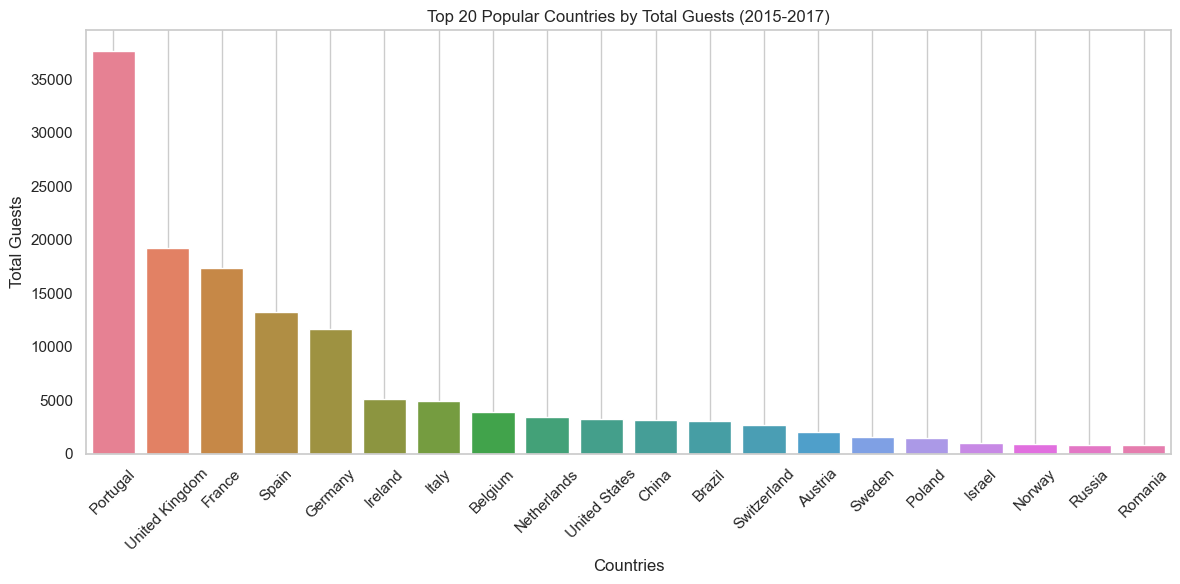

In [49]:
# Chart showing Top 20 Popular Countries by Total Guests

plt.figure(figsize=(12, 6))
sns.barplot(data=top_popularity_by_guests, x='country_name', y='total_guests', hue='country_name')
plt.title('Top 20 Popular Countries by Total Guests (2015-2017)')
plt.xlabel('Countries')
plt.ylabel('Total Guests')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
# Save the figure
output_file_path="output_data/Top 20 popular countries by total guests 2015-2017.png"
plt.savefig(output_file_path)

plt.show()

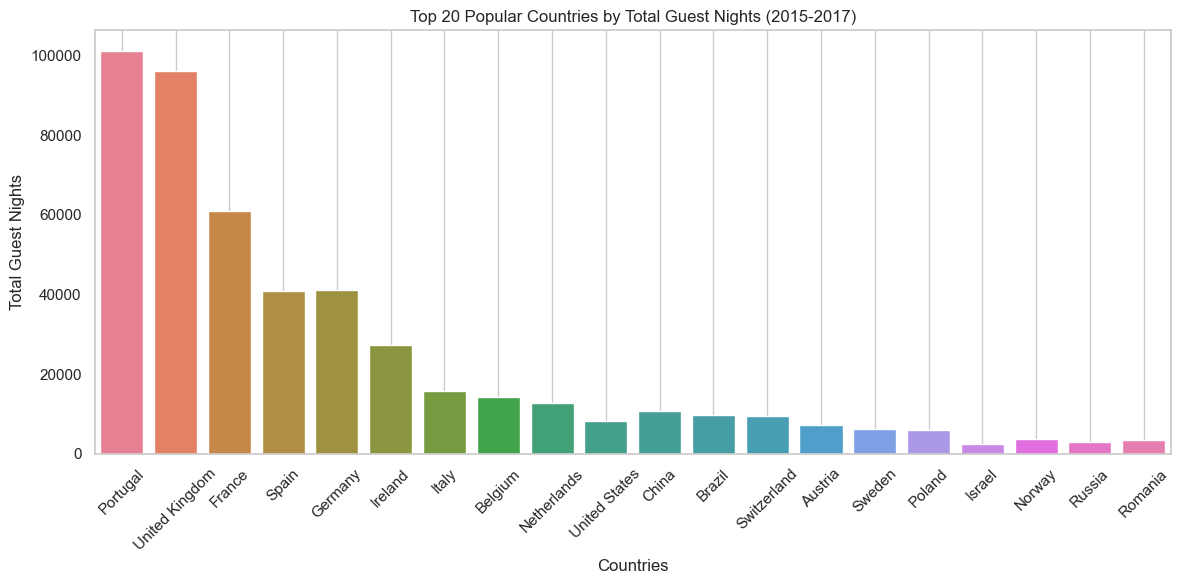

In [50]:
# Chart showing Top 20 Popular Countries by Total Guest Nights

plt.figure(figsize=(12, 6))
sns.barplot(data=top_popularity_by_guests, x='country_name', y='total_guest_nights', hue='country_name')
plt.title('Top 20 Popular Countries by Total Guest Nights (2015-2017)')
plt.xlabel('Countries')
plt.ylabel('Total Guest Nights')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
# Save the figure
output_file_path="output_data/Top 20 popular countries by total guest nights 2015-2017.png"
plt.savefig(output_file_path)

plt.show()

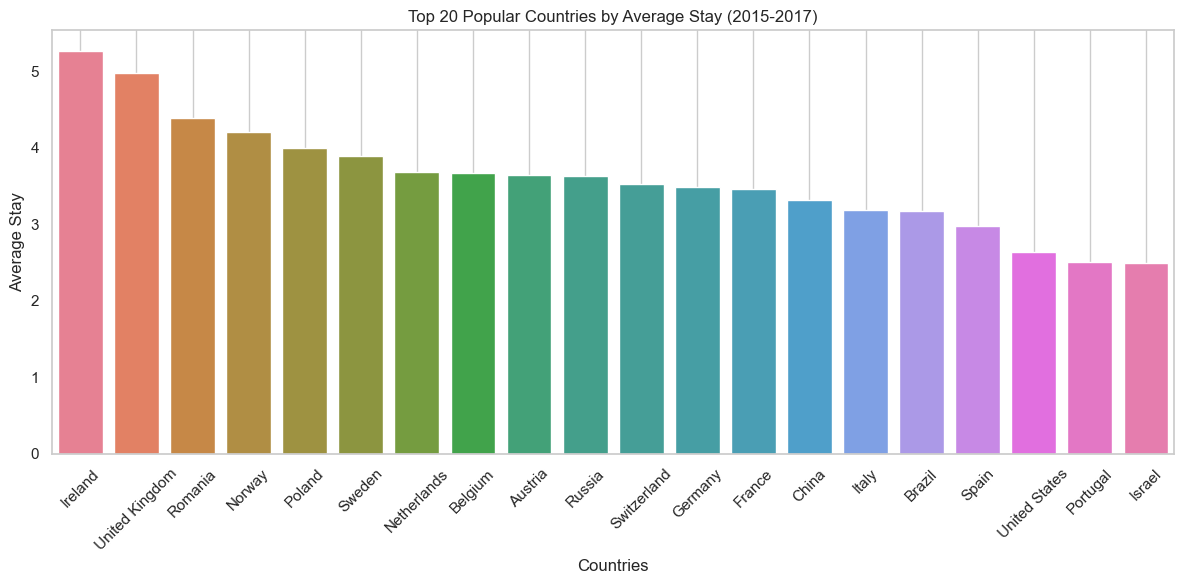

In [51]:
# Chart showing Top 20 Countries by Average Stay

plt.figure(figsize=(12, 6))
sns.barplot(data=top_popularity_by_average_stay, x='country_name', y='average_stay', hue='country_name')
plt.title('Top 20 Popular Countries by Average Stay (2015-2017)')
plt.xlabel('Countries')
plt.ylabel('Average Stay')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
# Save the figure
output_file_path="output_data/Top 20 popular countries by average stay 2015-2017.png"
plt.savefig(output_file_path)

plt.show()

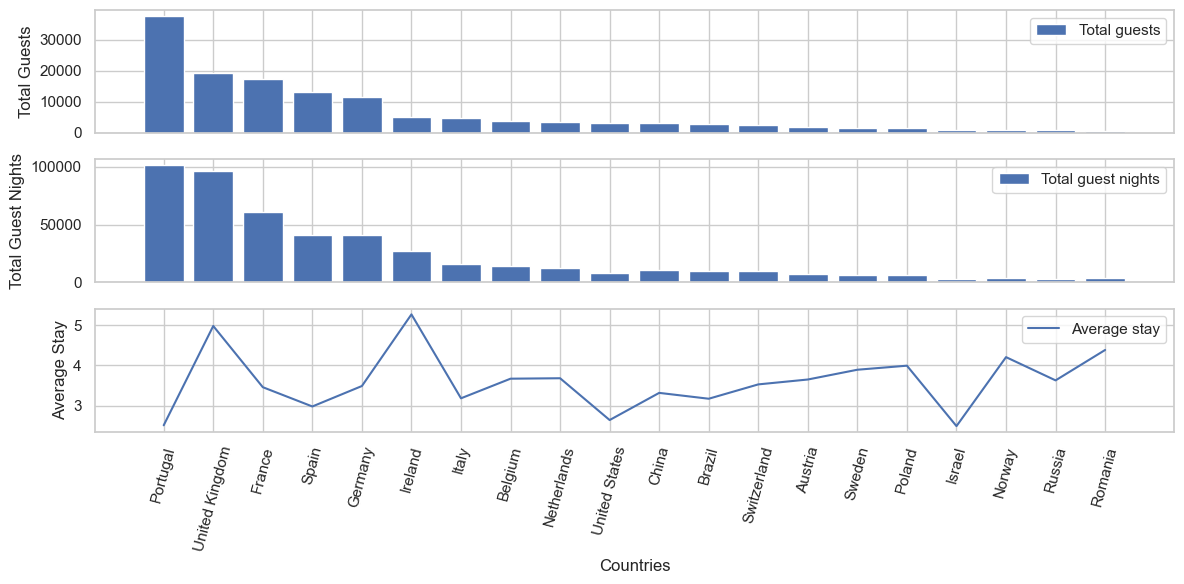

In [52]:
# Create a figure and subplots
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(12, 6))

# Plot data on the individual axes
ax[0].bar(top_popularity_by_guests['country_name'], top_popularity_by_guests['total_guests'], label='Total guests')
ax[0].set_ylabel('Total Guests')
ax[0].legend()

ax[1].bar(top_popularity_by_guests['country_name'], top_popularity_by_guests['total_guest_nights'], label='Total guest nights')
ax[1].set_ylabel('Total Guest Nights')
ax[1].legend()

ax[2].plot(top_popularity_by_guests['country_name'], top_popularity_by_guests['average_stay'], label='Average stay')
ax[2].set_ylabel('Average Stay')
ax[2].set_xlabel('Countries')
ax[2].legend()
plt.xticks(rotation=75)
sns.set(style="whitegrid")

# Display the plot
plt.tight_layout()

# Save the figure
output_file_path="output_data/Overview of top 20 popular countries by guests 2015-2017.png"
plt.savefig(output_file_path)

plt.show()

In [53]:
# Define the API parameters
params = {
    "apiKey":geoapify_key,
    "format":"json"
}

# Set the base URL
base_url = "https://api.geoapify.com/v1/geocode/search"

In [54]:
# Print a message to follow up the airport search
print("Starting country search")

# Loop through the top_popularity_by_guests DataFrame and search coordinates for country
for index, row in top_popularity_by_guests.iterrows():

    # Get the country to the string so geoapify finds the correct country
    country_name = row["country_name"]

    # Add the current city to the parameters
    params["text"] = f"{country_name}"

    # Make the API request
    response = requests.get(base_url, params=params)
    
    # Convert response to JSON
    response = response.json()

    # Extract latitude and longitude
    top_popularity_by_guests.loc[index, "Lat"] = response["results"][0]["lat"]
    top_popularity_by_guests.loc[index, "Lon"] = response["results"][0]["lon"]
    top_popularity_by_guests.loc[index, "country_name"] = response["results"][0]["country"]
    # Log the search results
    print(f"Coordinates for {country_name} fetched...")

# Display sample data to confirm that the coordinates appear
top_popularity_by_guests

Starting country search
Coordinates for Portugal fetched...
Coordinates for United Kingdom fetched...
Coordinates for France fetched...
Coordinates for Spain fetched...
Coordinates for Germany fetched...
Coordinates for Ireland fetched...
Coordinates for Italy fetched...
Coordinates for Belgium fetched...
Coordinates for Netherlands fetched...
Coordinates for United States fetched...
Coordinates for China fetched...
Coordinates for Brazil fetched...
Coordinates for Switzerland fetched...
Coordinates for Austria fetched...
Coordinates for Sweden fetched...
Coordinates for Poland fetched...
Coordinates for Israel fetched...
Coordinates for Norway fetched...
Coordinates for Russia fetched...
Coordinates for Romania fetched...


,country,total_guests,average_stay,total_guest_nights,country_name,Lat,Lon
124,PRT,37670.0,2.508519,101356.0,Portugal,39.662165,-8.135352
56,GBR,19258.0,4.979434,96277.0,United Kingdom,54.702354,-3.276575
53,FRA,17299.0,3.456550,60881.0,France,46.603354,1.888334
49,ESP,13213.0,2.976686,40979.0,Spain,39.326068,-4.837979
41,DEU,11659.0,3.485582,41212.0,Germany,51.163818,10.447831
69,IRL,5102.0,5.267794,27177.0,Ireland,53.429500,-8.122748
74,ITA,4894.0,3.180025,15854.0,Italy,42.638426,12.674297
15,BEL,3855.0,3.668094,14324.0,Belgium,50.640281,4.666715
112,NLD,3374.0,3.679091,12623.0,Netherlands,52.247650,5.541247
157,USA,3212.0,2.639098,8279.0,United States of America,39.783730,-100.445882


In [55]:
# Convert response to JSON
print(json.dumps(response, indent=4, sort_keys=True))

{
    "query": {
        "parsed": {
            "country": "romania",
            "expected_type": "unknown"
        },
        "text": "Romania"
    },
    "results": [
        {
            "address_line1": "Romania",
            "address_line2": "",
            "bbox": {
                "lat1": 43.618682,
                "lat2": 48.2654738,
                "lon1": 20.2619955,
                "lon2": 30.0454257
            },
            "category": "administrative",
            "country": "Romania",
            "country_code": "ro",
            "datasource": {
                "attribution": "\u00a9 OpenStreetMap contributors",
                "license": "Open Database License",
                "sourcename": "openstreetmap",
                "url": "https://www.openstreetmap.org/copyright"
            },
            "formatted": "Romania",
            "lat": 45.9852129,
            "lon": 24.6859225,
            "place_id": "512f17f19d98af384059758cd0741bfe4640f00101f9014162010000000

In [56]:
# Configure the map of countries by total guest nights
map_popularity_total_guest_night = top_popularity_by_guests.hvplot.points(
    "Lon",
    "Lat",
    geo = True,
    tiles = "EsriNatGeo",
    frame_width = 700,
    frame_height = 500,
    size = "total_guest_nights",
    scale = 0.08,
    color = "country_name",
    hover_cols=['Lon','Lat','country_name', 'total_guests', 'total_guest_nights','average_stay_nights']
)
# Display the map plot
map_popularity_total_guest_night


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Lon,Lat]   (country_name,total_guest_nights,total_guests)

## Finding

Popular Destinations: What are the most popular destinations for travelers?

3 key metrics: Total Guests, Total Guest Nights, Average Stay

1. Top Destinations by Total Guests:
Total Guests represents the raw number of visitors to each country, giving us a straightforward understanding of the countries attracting the most tourists based on the volume of bookings.

Key Insights:

Portugal (PRT) tops the list, which indicates it is drawing the largest number of tourists overall. This could be due to the country's increasing popularity in recent years, bolstered by cultural and historical appeal, affordable travel options, and increasing international awareness.
United Kingdom (GBR) follows closely, which might indicate its strong appeal due to cultural landmarks, proximity to other European countries, and its role as a major international hub.
France (FRA), Spain (ESP), and Germany (DEU) make up the next few spots, which is consistent with their status as major global tourist destinations, benefiting from rich cultural offerings, major cities, and significant infrastructure.
Key Metric Impact: A high number of visitors is often a strong indicator of a country's tourism infrastructure, cultural offerings, and global appeal. However, Total Guests alone doesn’t necessarily capture the full picture of a destination's tourism appeal—this is where Total Guest Nights and Average Stay come into play.

2. Top Destinations by Total Guest Nights:
Total Guest Nights combines the number of guests with the length of their stay. This metric provides a fuller picture of a destination’s tourism impact, as it not only captures how many tourists visit but also how long they stay, which can have a significant effect on local economies (e.g., spending on accommodations, food, etc.).

Key Insights:

Portugal still leads the chart in Total Guest Nights due to a high number of visitors, supported by a relatively short average stay. However, United Kingdom (GBR) follows closely despite having fewer guests overall. This is because the average stay in the UK is much longer (4.98 nights) compared to Portugal's 2.51 nights. This shows that while Portugal is more popular in terms of sheer numbers, the UK benefits from longer stays, leading to a similar overall tourism impact in terms of guest nights.
France and Germany also feature highly, highlighting their sustained appeal across both dimensions: the number of guests and the average length of stay.
Spain, while having a high volume of visitors, has relatively shorter average stays, which affects its total guest nights.
Key Metric Impact: A high total number of guest nights indicates that a destination is attracting not only a lot of tourists but also encouraging them to stay for longer periods. Destinations with longer stays like the UK can sustain a high guest night volume even with fewer visitors compared to countries like Portugal.

3. Top Destinations by Average Stay (Nights):
This metric is important as it reveals which destinations attract tourists who tend to stay longer, suggesting a different kind of appeal, possibly to a more niche or luxury market. Longer stays might indicate tourists who are seeking a more immersive or relaxed experience.

Key Insights:

Ireland (IRL) has the longest average stay at 5.27 nights, which suggests it might be a destination catering to tourists seeking a more leisurely and relaxed experience. It could be appealing to those interested in scenic, slower-paced travel, or to those visiting less-touristy, rural destinations.
Norway (NOR) and Romania (ROU) also show relatively high average stays (4.20 and 4.38 nights, respectively), which again could indicate more specialized or niche tourism—such as nature tourism in Norway or cultural/historical tourism in Romania.
In contrast, France and Spain have shorter average stays (around 3.5 nights), which might suggest these destinations are popular for shorter holidays or city breaks.
Key Metric Impact: A longer average stay might indicate that tourists are investing more time in exploring the destination, perhaps for a more immersive or niche experience. This metric is valuable for understanding tourism in areas that are not the top-of-mind but cater to a different type of traveler.

4. Total Guest Nights per Country:
This is essentially a combination of both the number of guests and their average length of stay. It provides a comprehensive view of the overall tourism demand for a destination.

Key Insights:

Portugal (101,356 guest nights) and United Kingdom (96,277 guest nights) are at the top, showing that both countries are major tourism hubs not only in terms of total visitors but also in the length of stay.
Germany and France also show high total guest nights, indicating their steady global appeal.
Smaller countries with higher average stays like Norway, Romania, and Israel may not top the chart for total guest nights but still maintain significant tourism engagement based on their high-quality, specialized offerings.
Key Metric Impact: This metric highlights overall tourism demand and helps identify countries that attract both a high number of visitors and those that are engaging tourists for longer periods of time. It’s a powerful indicator of how tourism is impacting each country's economy and infrastructure.

5. Observations from the Map:
Looking at the geographical spread of these countries on a map allows for the identification of clusters of popular destinations.

Western Europe Dominance: As expected, Western European countries like Portugal, United Kingdom, France, Germany, and Spain dominate in terms of guest nights. This suggests that these regions have well-established tourism industries with strong international appeal.

Other Regions: Countries like China and Russia show up in terms of guest nights, although their figures are somewhat lower. Their geographical spread, however, highlights that tourism is not just concentrated in Europe—there are also growing tourist flows from regions like Asia and Eastern Europe.

Smaller but Specialized Destinations: Ireland, Norway, Romania, and Israel are examples of countries with high average stays but fewer total guest nights. This points to a different kind of tourism model, possibly catering to niche markets (e.g., adventure tourism, historical tourism, etc.).

Conclusion:
The popularity of tourist destinations is driven not just by the number of visitors, but also by factors like the average length of stay and total guest nights. While Portugal has the highest number of visitors, its shorter average stay keeps it at a comparable level to other countries like the United Kingdom, where longer stays balance out the lower number of visitors. Countries like Ireland and Norway may not attract as many visitors overall, but their high average stay indicates that their tourism industry is catering to travelers seeking more immersive experiences.

The popularity of a destination is, therefore, a combination of these factors, and understanding the balance between total guests and average stay can provide deeper insights into the nature of tourism in each country.

Further Insights to Explore:
Hotel Ratings & Bookings: Combining this analysis with insights from Hetal on Hotel Ratings & Bookings would add another layer of understanding, as higher hotel ratings may correlate with longer stays or higher guest satisfaction, which could further affect a destination's popularity.


